## HiRISE数据处理
### Z字一维数据

In [1]:
import hirise_update
from asgiref.sync import sync_to_async

# 使用sync_to_async装饰器将同步函数转换为异步函数
update_hirise_dtm_data_async = sync_to_async(hirise_update.update_hirise_dtm_data)

# 在异步上下文中调用异步函数
await update_hirise_dtm_data_async()

AttributeError: module 'hirise_update' has no attribute 'update_hirise_dtm_data'

In [2]:
img_path = 'data/DTM/DTEEC_001336_1560_001534_1560_U01.IMG'
jpg_path = 'data/JPG/DTEEC_001336_1560_001534_1560_U01.ca.jpg'
PRODUCT_ID = 'DTEEC_001336_1560_001534_1560_U01'

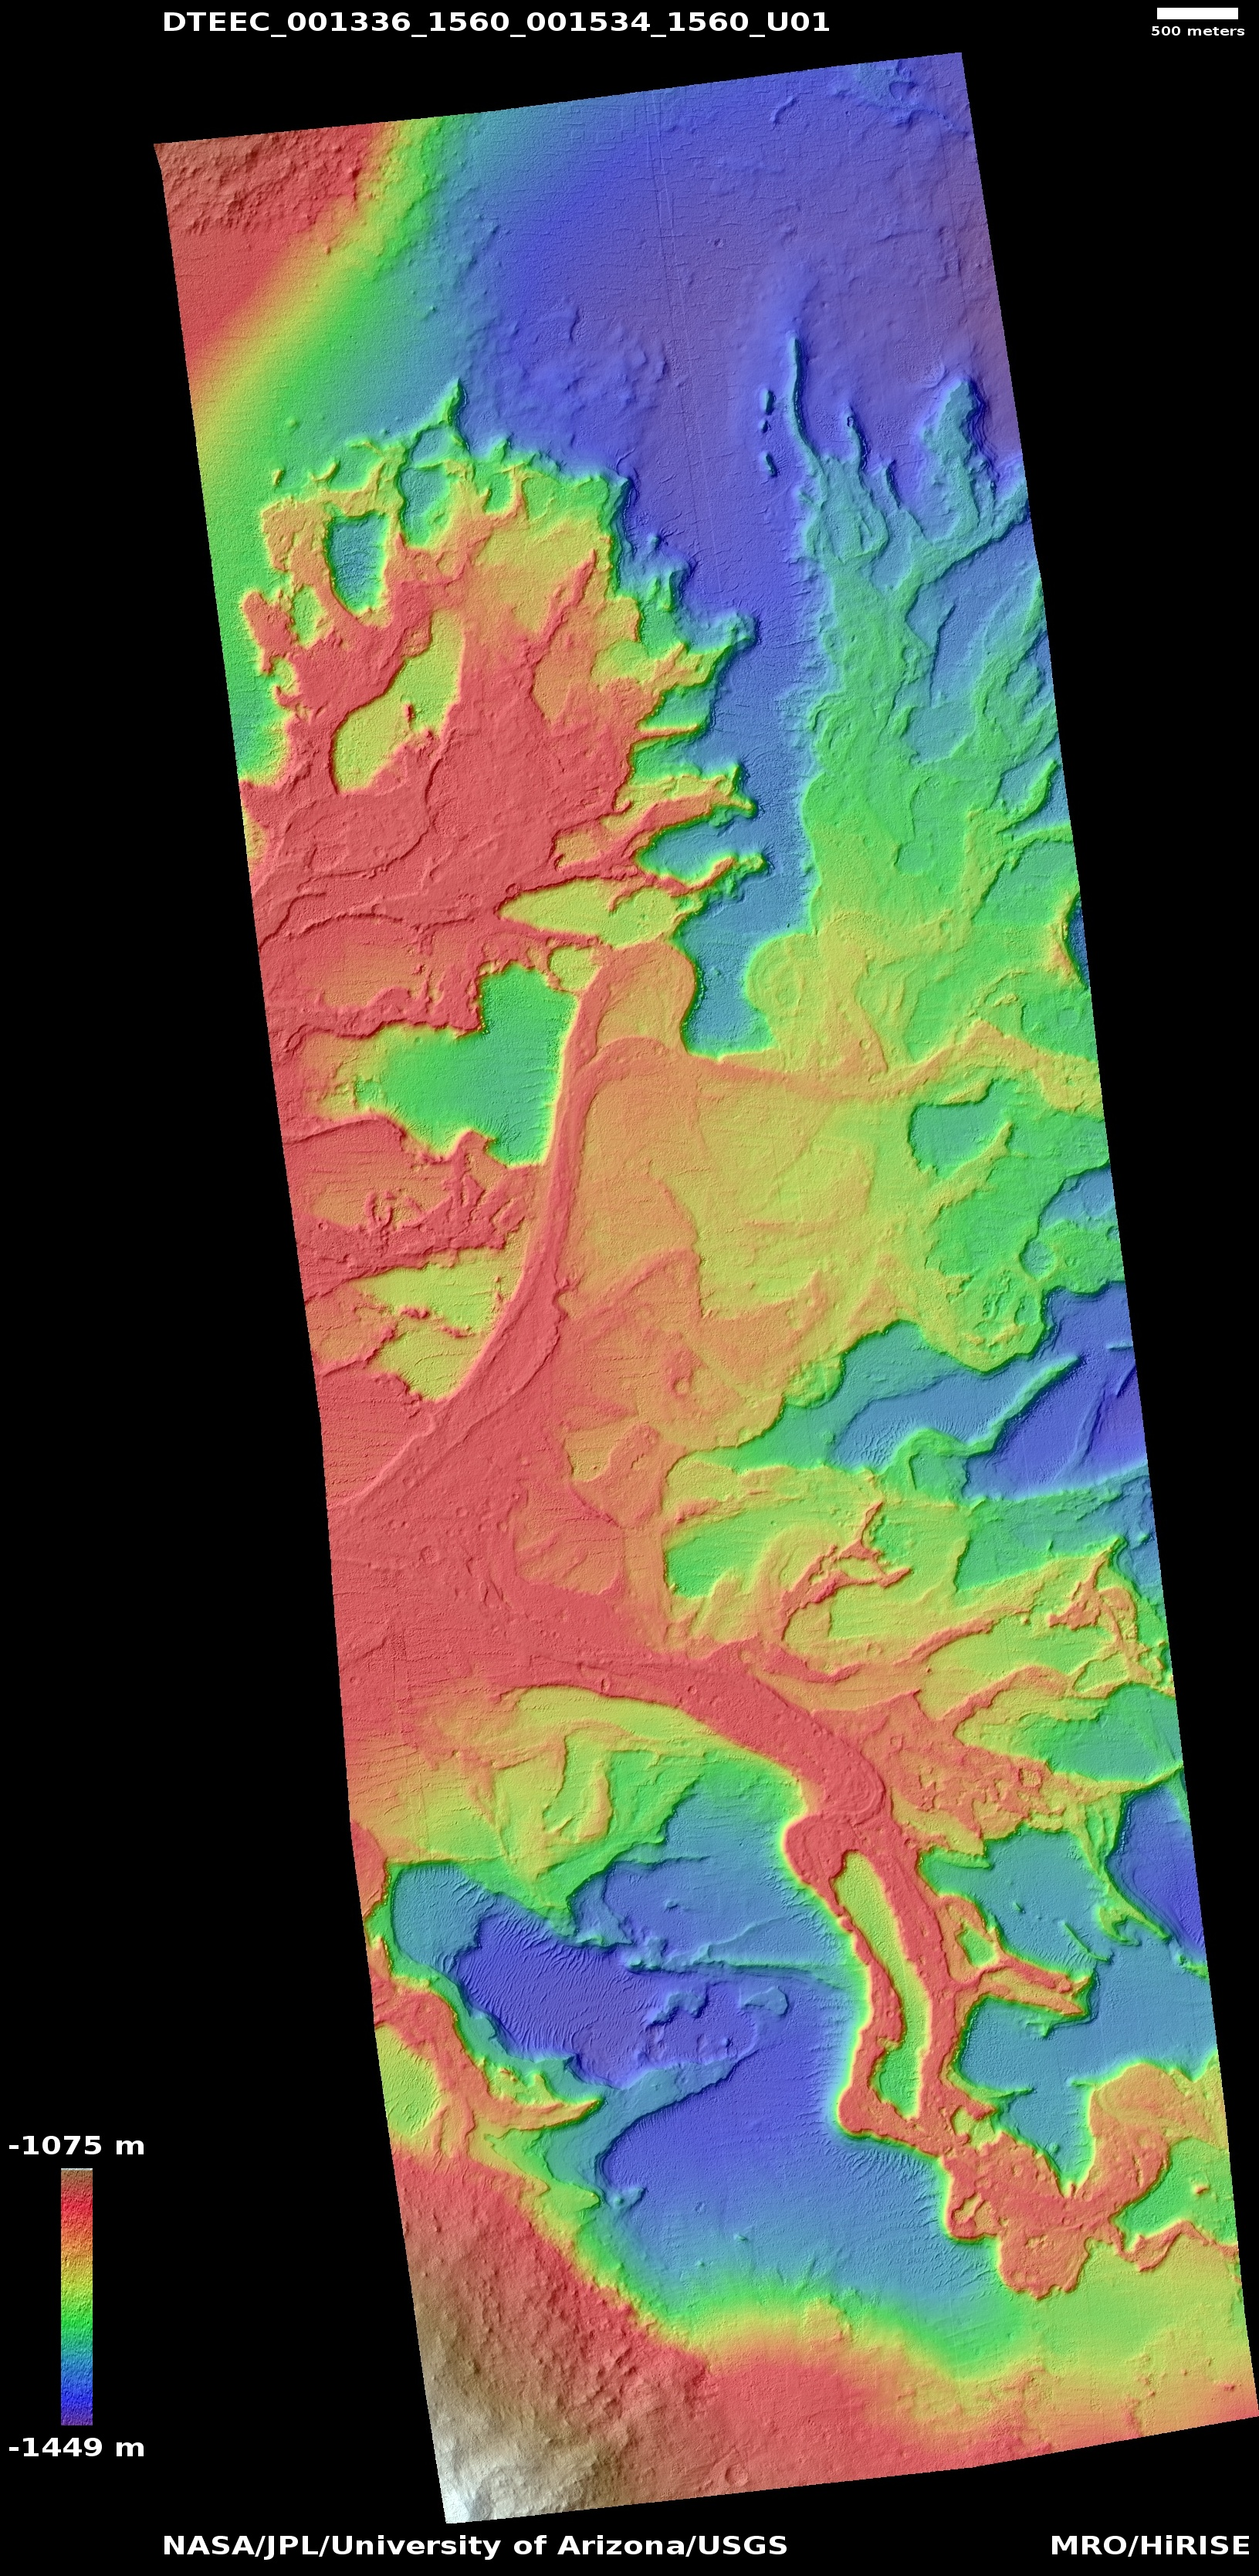

In [3]:
# 显示jpg
from IPython.display import Image

Image(filename=jpg_path)

In [4]:
# DSMAP_urls = 'https://www.uahirise.org/PDS/CATALOG/DSMAP.CAT'
# DSMAP_urls_save_path = 'data/DTM/DSMAP.CAT'
# #下载
# import requests
# r = requests.get(DSMAP_urls)
# with open(DSMAP_urls_save_path, 'wb') as f:
#     f.write(r.content)

In [5]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

dataset = gdal.Open(img_path, gdal.GA_ReadOnly)
# 读取数据
data = dataset.ReadAsArray()
# 获取数据信息
print('Driver: ', dataset.GetDriver().ShortName, '/', dataset.GetDriver().LongName)
print('Size is ', dataset.RasterXSize, 'x', dataset.RasterYSize, 'x', dataset.RasterCount)
print('Projection is ', dataset.GetProjection())
geotransform = dataset.GetGeoTransform()
if not geotransform is None:
    print('Origin = (', geotransform[0], ',', geotransform[3], ')')
    print('Pixel Size = (', geotransform[1], ',', geotransform[5], ')')
# ignore_value
ignore_value = dataset.GetRasterBand(1).GetNoDataValue()
print('ignore_value: ', ignore_value)

Driver:  PDS / NASA Planetary Data System
Size is  6789 x 15166 x 1
Projection is  PROJCS["EQUIRECTANGULAR MARS",GEOGCS["GCS_MARS",DATUM["D_MARS",SPHEROID["MARS_localRadius",3393833.2607584,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",-20],PARAMETER["central_meridian",326.38],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Origin = ( -3169.805070945348 , -1404516.0266675774 )
Pixel Size = ( 1.0082077197663 , -1.0082077197663 )
ignore_value:  -3.4028226550889045e+38


In [6]:
# 偶数行反转
data[::2, :] = data[::2, ::-1]
# flatten
data = data.flatten()
data.shape

(102961974,)

In [7]:
# 删除ignore_value
data = data[data != ignore_value]
data.shape

(74134352,)

In [8]:
map_scale = 1.01
actural_interval = 20  # m
interval = int(actural_interval / map_scale)

In [9]:
data = np.pad(data, (interval, interval), 'edge')

In [10]:
from scipy.signal import convolve

# 对间隔interval的数据进行拟合，得到大范围的data的趋势
filter_kernel = np.ones(interval) / interval
# 应用滤波器,边界填充方式为镜像填充
filtered_data = convolve(data, filter_kernel, mode='same', method='auto')

In [11]:
# 去除边界
filtered_data = filtered_data[interval:-interval]
data = data[interval:-interval]

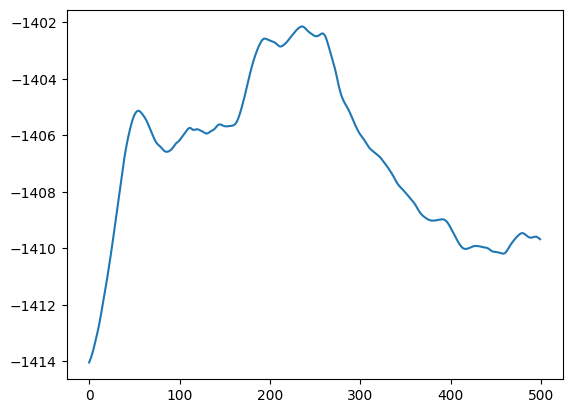

In [15]:
plt.plot(filtered_data[40750:41250])
plt.savefig("filtered_data.png")

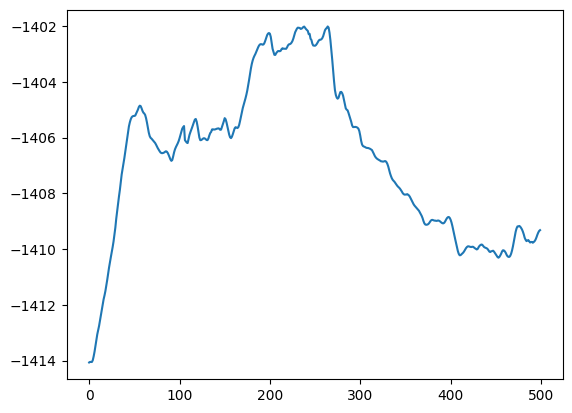

In [16]:
plt.plot(data[40750:41250])
plt.savefig("origin_data.png")

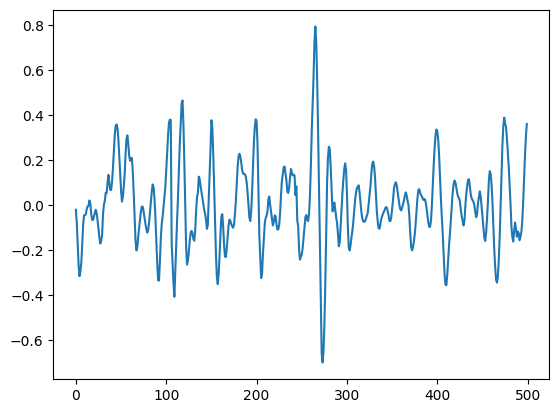

In [17]:
# 去除趋势
plt.plot(data[40750:41250] - filtered_data[40750:41250])
plt.savefig("data-filtered_data.png")

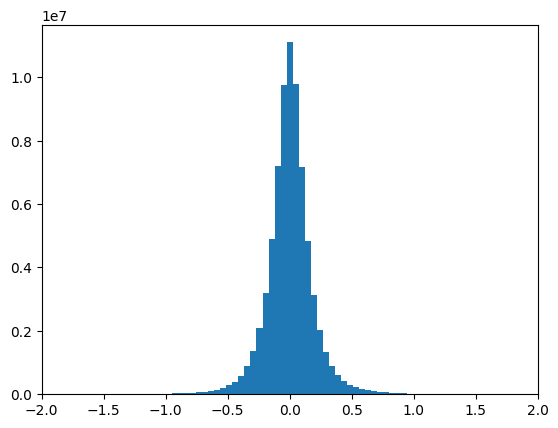

In [21]:
# 做直方图
plt.hist(data - filtered_data, bins=500)
# 限制x轴范围
plt.xlim(-2, 2)
plt.savefig("hist.png")

In [17]:
A = data - filtered_data
A

array([ 0.00884689, -0.01058799, -0.02948962, ..., -0.13531173,
       -0.14291864, -0.19292892])

In [18]:
import scipy.signal as signal
import numpy as np


# 计算相关长度
def calculate_correlation_length(A, dr):
    # 求1D、2D粗糙面相关长度
    # input:
    #     A:粗糙面的高度坐标
    #     dr：横向分辨率（如果是2D粗糙面，假设是x方向和y方向分辨率是一样的）
    # output:
    #     val:1D粗糙面返回1个值
    #         2D粗糙面返回一个1*2的向量
    #             第一个为A[:,0]方向
    #             第二个为A[0,:]方向
    er = 1e-1  # 误差
    m = A.shape
    if len(m) > 2 or len(m) == 0:
        print('input error')
        return []
    elif len(m) == 1:
        avg = np.mean(A)
        A = A - avg

        n = np.prod(A.shape)
        x = np.arange(0, n) * dr

        C = signal.correlate(A, A)
        h = max(C)
        dff = C[n - 1:] - h / np.exp(1)
        if np.sum(np.abs(dff) < er) == 1:
            return x[np.abs(dff) < er][0]
        else:
            index = np.where(dff < 0)[0][0]
            x1 = x[index]
            x2 = x[index - 1]
            y1 = abs(dff[index])
            y2 = dff[index - 1]
            return (y1 * x1 + y2 * x2) / (y1 + y2)
    else:
        avg = np.mean(A)
        A = A - avg

        C1 = np.zeros(m[0])
        for ii in range(m[0]):
            C1[ii] = np.sum(A[0:-ii or None, :] * A[ii:, :])

        x = np.arange(0, m[0]) * dr
        h = max(C1)
        dff = C1 - h / np.exp(1)
        if np.sum(np.abs(dff) < er) == 1:
            val = np.array([x[np.abs(dff) < er][0]])
        else:
            index = np.where(dff < 0)[0][0]
            x1 = x[index]
            x2 = x[index - 1]
            y1 = abs(dff[index])
            y2 = dff[index - 1]
            val = np.array([(y1 * x1 + y2 * x2) / (y1 + y2)])

        C1 = np.zeros(m[1])
        for ii in range(m[1]):
            C1[ii] = np.sum(A[:, 0:-ii or None] * A[:, ii:])

        x = np.arange(0, m[1]) * dr
        h = max(C1)
        dff = C1 - h / np.exp(1)
        if np.sum(np.abs(dff) < er) == 1:
            return np.append(val, x[np.abs(dff) < er][0])
        else:
            index = np.where(dff < 0)[0][0]
            x1 = x[index]
            x2 = x[index - 1]
            y1 = abs(dff[index])
            y2 = dff[index - 1]
            return np.append(val, (y1 * x1 + y2 * x2) / (y1 + y2))

In [19]:
 # 窗口长度
window_length = 1000
window_length = int(window_length / map_scale)
hanning_window = np.hanning(window_length)

In [20]:
import tqdm
data_length = len(A)
step_size = 500  # 你可以根据需要调整此值
correlation_lengths = []
pbar = tqdm.tqdm(total=data_length - window_length + 1)
for start in range(0, data_length - window_length + 1, step_size):
    segment = A[start:start+window_length]
    
    # 应用Hanning窗
    windowed_segment = segment * hanning_window
    
    # 计算相关长度
    corr_length = calculate_correlation_length(windowed_segment, dr=map_scale)  # 假设dr=1，你可以根据需要调整
    correlation_lengths.append(corr_length)
    pbar.update(step_size)


100%|█████████▉| 73946000/74133363 [00:39<00:00, 1885258.98it/s]

In [20]:
# from concurrent.futures import ThreadPoolExecutor, as_completed
# import multiprocessing
# from tqdm import tqdm
# 
# # 设置线程池的数量，可以根据需要进行调整
# num_threads = multiprocessing.cpu_count()
# 
# # 创建线程池
# with ThreadPoolExecutor(max_workers=num_threads) as executor:
#     futures = [executor.submit(CalculateCorrelationLength, window) for window in A_windows]
# 
#     # 使用as_completed来迭代已完成的任务，并显示进度条
#     for future in tqdm(as_completed(futures), total=len(futures)):
#         pass
# 
# # 获取结果
# correlation_lengths = [future.result() for future in futures]
# 
# # 打印结果
# correlation_lengths

In [21]:
# import tqdm
# 
# correlation_lengths = []
# pbar = tqdm.tqdm(total=len(A_windows))
# for index, window in enumerate(A_windows):
#     # tqdm显示进度条
#     pbar.update(1)
#     correlation_lengths.append(calculate_correlation_length(window, map_scale))

100%|█████████▉| 748212/748832 [00:45<00:00, 16629.77it/s]

In [31]:
correlation_lengths

[2.7290725487156178,
 2.3144833165592584,
 3.195006303776074,
 2.44604472374287,
 2.0725096692618847,
 2.4314647710722213,
 2.4819667650365598,
 2.350130175241375,
 2.538550378282543,
 2.3237816389899093,
 2.9795626199107184,
 2.168990831548832,
 2.187343470899441,
 3.8876116642221064,
 2.7039248865091072,
 2.4286499862545465,
 3.6207645936046613,
 3.607331515919939,
 2.46161308313347,
 2.221624580001618,
 3.9809926114355227,
 2.046430551061278,
 2.553998640141291,
 3.4176270754477907,
 4.002988864674042,
 2.1550039895713495,
 3.7764086431421835,
 3.7432807241588617,
 2.098255717762973,
 3.7408490976956568,
 3.9432562421973483,
 3.905893954369716,
 2.2177635502129722,
 3.9219255435288036,
 3.487938638427568,
 2.2685442125120403,
 3.851708529009489,
 2.5207924995720723,
 3.460960960591286,
 2.272788845021131,
 3.564219598148026,
 2.5202494893905203,
 2.4495552830059606,
 3.3154240125607783,
 2.0212267963842545,
 3.701809876891078,
 3.995549775786471,
 2.926497455713121,
 2.1949022302713

74133500it [00:50, 1885258.98it/s]                              

(array([1.0000e+01, 2.0000e+00, 0.0000e+00, 2.7247e+04, 8.8910e+03,
        6.1800e+02, 2.0045e+04, 2.3765e+04, 4.0767e+04, 1.6989e+04,
        1.3730e+03, 3.7990e+03, 3.1680e+03, 7.0000e+01, 1.4700e+02,
        1.7100e+02, 1.2000e+01, 2.1000e+01, 2.3000e+01, 1.0000e+00,
        3.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 8.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.7000e+01, 0.0000e+00, 0.0000e+00, 6.0000e+01,
        0.0000e+00, 0.0000e+00, 6.1000e+01, 0.0000e+00, 0.0000e+00,
        6.4000e+01, 0.0000e+00, 0.0000e+00, 3.8000e+01, 0.0000e+00,
        0.0000e+00, 4.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.3000e+01, 0.0000e+00, 0.0000e+00, 2.6000e+01, 0.0000e+00,
        0.0000e+00, 1.4000e+01, 0.0000e+00, 0.0000e+00, 2.2000e+01,
        0.0000e+00, 0.0000e+00, 1.6000e+01, 0.00

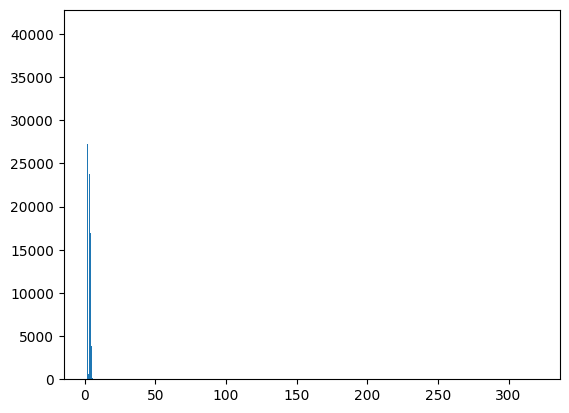

In [21]:
# 绘制correlation_lengths的直方图
plt.hist(correlation_lengths, bins=1000)

In [21]:
np.max(correlation_lengths)

320.17

In [22]:
np.min(correlation_lengths)

1.03628958955253

{'whiskers': [<matplotlib.lines.Line2D at 0x261bb243250>,
 'caps': [<matplotlib.lines.Line2D at 0x261bb2437f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x261bb2430a0>],
 'medians': [<matplotlib.lines.Line2D at 0x261bb243d90>],
 'fliers': [],
 'means': []}

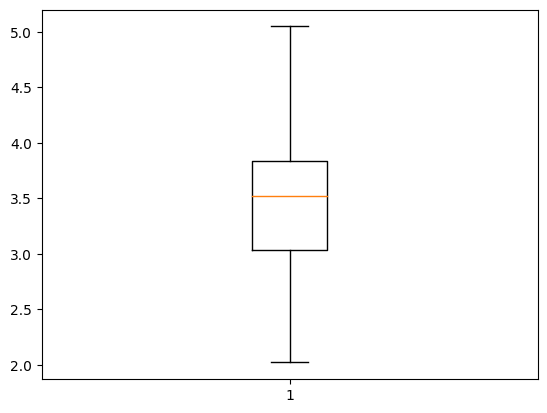

In [24]:
# 绘制correlation_lengths的箱图，不包括异常值
plt.boxplot(correlation_lengths, showfliers=False)